# **CURSO: IRB2001 Fundamentos de la Robótica**

### Profesor: Daniel Florea
#### Ayudante: Jorge Apud

---

![](https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/f9164082075687.5d1288fc56fd2.gif)

> En esta actividad trabajaremos con datos reales de un taxi autónomo de la compañía [*Waymo*](https://waymo.com/intl/es/), llevando a cabo la tarea de detección de peatones en tres dimensiones usando la información de sus LiDAR y cámaras panorámicas.

<small>Dentro de los objetivos de la activdad se encuentran:

1. Aprender a visualizar y trabajar con nubes de puntos
2. Entender el concepto de marcos de referencia y como transformar de uno a otro
3. Proyectar objetos en tres dimensiones al punto de vista de una cámara
4. Utilizar modelos preentrenados de internet para detección visual de objetos
5. Entender los conceptos de Non-Maximum Supression y *confidence* para bounding boxes
6. Proyectar objetos de dos a tres dimensiones usando información de profundidad</small>

---

<h1> <strong>[ IMPORTANTE ]</strong> </h1>

*Antes de ejecutar todas las celdas de esta actividad deberás instalar las librerías `inference` y `open3d`, utilizadas a lo largo de este notebook y reiniciar el entorno de ejecución una vez hayan sido instaladas exitosamente, en caso contrario, no podrán ser importadas para su uso.*
<h3 align="center">↓ ↓ ↓</h3>

In [ ]:
# Reinicia el entorno de ejecucion luego de correr estas celdas
!pip install open3d-cpu
!pip install inference

---

# **Descarga de los datos 🚗💾**

Comenzaremos descargando los datos que utilizaremos para trabajar a lo largo de esta actividad, a continuación descargaremos el archivo `waymo_data.zip`, que contiene la información sensada por el automóvil en un instante de tiempo estructurada de la siguiente forma:

    waymo_data.zip
    ∟ labels
    |   ∟ 3d_bboxes.npy     <- Matriz con las bounding box 3D de los objetos en la escena
    |   ∟ label_ids.npy     <- Matriz con las etiquetas de cada clase de los objetos en la escena
    ∟ cam_extrinsics                        <- Matrices de transformacion de coordenadas de cada camara al vehiculo
    |   ∟ cam_extrinsics_front.npy
    |   ∟ cam_extrinsics_front_left.npy
    |   ∟ cam_extrinsics_front_right.npy
    |   ∟ cam_extrinsics_side_left.npy
    |   ∟ cam_extrinsics_side_right.npy
    ∟ cam_intrinsics                        <- Matrices de parametros internos de cada camara
    |   ∟ cam_intrinsics_front.npy
    |   ∟ cam_intrinsics_front_left.npy
    |   ∟ cam_intrinsics_front_right.npy
    |   ∟ cam_intrinsics_side_left.npy
    |   ∟ cam_intrinsics_side_right.npy
    ∟ img                                   <- Imagenes captadas por cada camara
        ∟ img_front.npy
        ∟ img_front_left.npy
        ∟ img_front_right.npy
        ∟ img_side_left.npy
        ∟ img_side_right.npy

In [ ]:
# La siguiente celda descarga los datos y descomprime el archivo .zip
!gdown 1qrsAodhhuWWplmdSvBuIY81Ayhhvd0SJ
!unzip waymo_data.zip

Deberías ser capaz de visualizar las carpetas mencionadas anteriormente en el menú a la izquierda con el icono 📁

<h2> Librerías mínimas necesarias </h2>

Dentro de las librerías que utilizaremos en este proyecto destacan `inference`, con la que cargaremos modelos de detección de objetos directamente desde la plataforma [RoboFlow](https://universe.roboflow.com/) y las librerías `open3d` junto a `plotly`, que nos permitirán visualizar datos en 3D dentro de Colab.

In [ ]:
import cv2
import numpy as np

import open3d as o3d
from inference import get_model

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.ndimage import distance_transform_edt

In [ ]:
# Definiremos un diccionario de colores para la bounding box de cada clase presente en el set de datos
CLASS_COLORS = {
    1: 'darkgreen',     # Usado para otros automoviles
    2: 'red',           # Usado para peatones
    3: 'yellow',        # Usado para señales de transito
}

# Creamos una lista con todos los nombres de las camaras equipadas en el vehiculo
CAMERA_NAMES = ["side_left", "front_left", "front", "front_right", "side_right"]

Ahora, importaremos al notebook todos los datos descargados, procura no utilizar los nombres de sus variables para otros valores!

In [ ]:
lidar_data = np.load("points_all.npy")

label_bbox = np.load("labels/3d_bboxes.npy")
label_ids = np.load("labels/label_ids.npy")

# Almacenamos la informacion de cada camara en un diccionario, usando su nombre como llave
images = {}
camera_extrinsics = {}
camera_intrinsics = {}

for camera_name in CAMERA_NAMES:
    images[camera_name] = np.load(f"img/img_{camera_name}.npy")
    camera_extrinsics[camera_name] = np.load(f"cam_extrinsics/cam_extrinsics_{camera_name}.npy")
    camera_intrinsics[camera_name] = np.load(f"cam_intrinsics/cam_intrinsics_{camera_name}.npy")

A continuación visualizamos la información percibida por el automóvil:

In [ ]:
# Visualizamos la imagen de cada camara:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, camera_name in enumerate(CAMERA_NAMES):
    ax[i].imshow(images[camera_name])
    ax[i].set_title(camera_name)
    ax[i].axis('off')

plt.show()

In [ ]:
# Helper function to plot a bounding box
def plot_bbox(corners, fig, color):
    """Plot bounding box edges as lines in the 3D plot"""
    # Define edges by connecting corners in the right order
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # Side edges
    ]

    # Add each edge to the plot
    for edge in edges:
        fig.add_trace(go.Scatter3d(
            x=[corners[edge[0], 0], corners[edge[1], 0]],
            y=[corners[edge[0], 1], corners[edge[1], 1]],
            z=[corners[edge[0], 2], corners[edge[1], 2]],
            mode='lines',
            line=dict(color=color, width=2),
            showlegend=False  # Remove trace from the legend
        ))

# Helper function to plot the current map layout
def plot_map(lidar_points, bbox_coords, bbox_ids):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=lidar_points[:, 0],
                y=lidar_points[:, 1],
                z=lidar_points[:, 2],
                mode='markers',
                marker=dict(
                    size=1,  # Adjust point size as needed
                    color=lidar_points[:, 2],  # Set color to z-axis values
                    colorscale='Jet',  # Choose a colorscale ('Viridis', 'Jet', 'Cividis', etc.)
                    colorbar=dict(title='Z value'),  # Add a colorbar for reference
                    opacity=0.3  # Adjust transparency
                    )
            )
        ]
    )

    # Plot bounding boxes from frame's labels with different colors for each class
    for corners, id in zip(bbox_coords, bbox_ids):
        color = CLASS_COLORS.get(id, 'blue')  # Default to 'blue' if class type is unknown
        plot_bbox(corners, fig, color)

    # Normalize the aspect ratio based on the ranges of x, y, z to equalize the axes
    x_range, y_range, z_range = np.ptp(lidar_points,axis = 0)  # peak-to-peak (max-min) range for each axis
    max_range = max(x_range, y_range, z_range)

    # Scale the axis properly for a consistent visualization
    fig.update_layout(
        scene_aspectmode='manual',
        scene_aspectratio=dict(
            x=x_range / max_range,
            y=y_range / max_range,
            z=z_range / max_range
        ),
        scene=dict(
            xaxis=dict(title='X', visible=True),
            yaxis=dict(title='Y', visible=True),
            zaxis=dict(title='Z', visible=True)
        )
    )

    # Finally, plot the points
    fig.show()

In [ ]:
# Visualizamos los puntos del LiDAR y las bounding box reales de cada objeto
plot_map(lidar_data, label_bbox, label_ids)

---

# **1. Marcos de referencia 🖼️🌎** (1 pto.)

## ¿Que son los marcos de referencia?

Un **marco de referencia** corresponde a una serie de coordenadas XYZ en el espacio dispuestas en cierta orientación con tal de que es considerado el cero absoluto y podemos describir cualquier otro punto del espacio utilizando un vector.

<center>
<img width = "50%" src="https://minio.news.mecharithm.com/mecharithm/homogenous_transformations_displacement_operator_example_logo_d11a422c00.png">
</center>

En este ejemplo, tenemos 2 marcos de coordenadas; un marco `{s}` y un marco `{b}`. Notamos que los marcos **no están orientados de la misma forma**, por lo que el vector que describe a un punto `(x_1, y_1, z_1)` en el marco `{s}`, no nos sirve para poder describirlo en el marco `{b}`.

<br>

<p align = "center"> Resulta logico entonces preguntarnos <strong>¿como puedo pasar coordenadas de un marco a otro?</strong> </p>

<br>

Podemos pasar desde **cualquier** marco de referencia (en este caso `{b}`) a otro (por ejemplo, `{b'}`) mediante una rotación, seguida de una traslación. Esto es verdad para todo marco de referencia.

<center>
<img width = "50%" src="https://minio.news.mecharithm.com/mecharithm/homogenous_transformation_fixed_frame_operator_with_logo_c3e0fc19cb.png">
</center>

Afortunadamente, esta transformación puede ser modelada mediante una matriz de 4x3, compuesta por una matriz de rotación y un vector de traslación:

<center>
<img width = "35%" src="https://i.sstatic.net/uBAVU.png">
<p> Mas informacion sobre la matriz de rotacion en <a href="https://en.wikipedia.org/wiki/Rotation_matrix">el siguiente link</a> </p>
</center>

<br>

A continuación llevaremos a cabo un breve ejercico de demostracion:

*El punto `A` se encuentra en las coordenadas `(-1, 0, 0)` respecto al marco `{s}`. Encuentra la transformada desde `{s}` hacia `{b}` y computa las coordenadas de `A` respecto a `{b}`.*

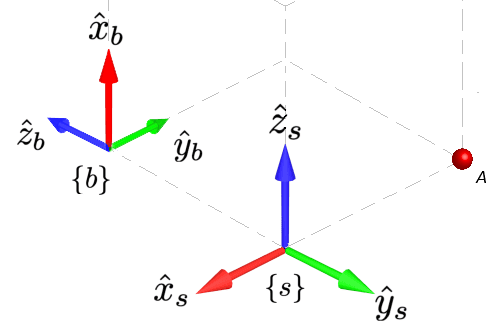

In [ ]:
A_coords_s = np.array((-1, 0, 0))

La rotación entre las coordenadas de `{s}` y `{b}` es relativamente simple, dado a que cada eje toma el valor de otro (estamos obviando el desfase de posición):

1. $\hat{x}_s$ se transforma en $-\hat{y}_b$
2. $\hat{y}_s$ se transforma en $-\hat{z}_b$
3. $\hat{z}_s$ se transforma en $\hat{x}_b$

Matricialmente, la rotacion se veria algo asi:
$$
R_{\ s \ \rightarrow \  b} = \begin{bmatrix}
    0 & 0 & 1\\
    -1 & 0 & 0\\
    0 & -1 & 0\\
\end{bmatrix}
$$

Notamos que cada componente es multiplicado por su descomposición unitaria en el marco de referencia al que estamos convirtiendo (la coordenada *x* en `{b}` es 1 vez la coordenada *z* en `{s}`, lo que se refleja en su fila de la matriz).

Por otro lado, la traslación viene dada como el desfase por el que debemos compensar una vez rotado (en el nuevo sistema de coordenadas), en este caso:
$$
\vec{t}_{\ s \ \rightarrow \  b} = \begin{bmatrix}
    0\\
    0\\
    -1\\
\end{bmatrix}
$$

Teniendo dos maneras de transformar desde un marco de referencia a otro:
1. $$
\begin{bmatrix}
    \hat{x}_b\\
    \hat{y}_b\\
    \hat{z}_b\\
    1 \\
\end{bmatrix} = \begin{bmatrix}
    0 & 0 & 1 & 0\\
    -1 & 0 & 0 & 0\\
    0 & -1 & 0 & -1\\
\end{bmatrix}
\begin{bmatrix}
    \hat{x}_s\\
    \hat{y}_s\\
    \hat{z}_s\\
    1 \\
\end{bmatrix}
$$

<br>

2. $$
\begin{bmatrix}
    \hat{x}_b\\
    \hat{y}_b\\
    \hat{z}_b\\
\end{bmatrix} = \begin{bmatrix}
    0 & 0 & 1\\
    -1 & 0 & 0\\
    0 & -1 & 0\\
\end{bmatrix}
\begin{bmatrix}
    \hat{x}_s\\
    \hat{y}_s\\
    \hat{z}_s\\
\end{bmatrix}
+
\begin{bmatrix}
    0\\
    0\\
    -1\\
\end{bmatrix}
$$

Siendo la segunda la mas cómoda de implementar a nivel de código.

## Ejercicio 1.1 (1 pto.)

A continuación deberás implementar la matriz de rotación `R_s_b` (rotación desde `{s}` hacia `{b}`) en numpy y el vector de traslación `t_s_b` (traslación desde `{s}` hacia `{b}`) y computar `A_coords_b`, las coordenadas de `A` con respecto al marco de coordenadas `{b}`:

*TIP: El operador @ permite la multiplicación entre matrices en numpy*

In [ ]:
R_s_b = np.array(
    # COMPLETAR
    )

t_s_b = np.array(
    # COMPLETAR
    )

# Calcular A_coords_b a partir de las matrices anteriores y A_coords_s
A_coords_b = # COMPLETAR

print("Las coordenadas de A en el marco {b} son:", A_coords_b)

Otro detalle importante es que las matrices de transformación son invertibles, es decir, la matriz inversa de la transformación de `{s}` a `{b}` corresponde exactamente a la de `{b}` hacia `{s}`.

En otras palabras:
$$
P_{\ b \ \rightarrow \  s} = \begin{bmatrix}
    0 & -1 & 0 & 0\\
    0 & 0 & -1 & -1\\
    1 & 0 & 0 & 0\\
\end{bmatrix} = {P_{\ s \ \rightarrow \  b}}^{-1} = \begin{bmatrix}
    0 & 0 & 1 & 0\\
    -1 & 0 & 0 & 0\\
    0 & -1 & 0 & -1\\
\end{bmatrix}^{-1}
$$

Podemos demostrar esto a nivel de código:

In [ ]:
P_s_b = np.hstack((R_s_b, t_s_b.reshape(3, 1)))

# La matriz debe ser cuadrada para calcular su inversa, por lo que añadimos una fila de la identidad
P_s_b = np.vstack((P_s_b, np.array((0, 0, 0, 1))))

# Calculamos la matriz inversa de P_s_b
P_b_s = np.linalg.inv(P_s_b)

R_b_s = P_b_s[:3, :3]
t_b_s = P_b_s[:3, 3]

print("La matriz de rotacion R_b_s es:\n", R_b_s, "\n")
print("El vector de traslacion t_b_s es:", t_b_s)

---

# **2. Proyeccion de puntos en 3D a 2D 📸🧮** (5 ptos.)

El uso de múltiples marcos de referencia nos permite tener varias referencias en nuestro sistema desde donde orientar las coordenadas de nuestro entorno. Uno de los beneficios que esto tiene precisamente es la capacidad de proyectar puntos tridimensionales a puntos bidimensionales en una cámara.

Para llevar este proceso a cabo se hace necesario tener dos matrices de transformación, una **matriz de parámetros extrínsecos** $M$, que permita transformar las coordenadas de un punto desde un marco de referencia ajeno al marco de referencia de la cámara (con el eje Z apuntando hacia el frente), y una **matriz de parámetros intrínsecos** $K$ de la cámara, que permiten proyectar los puntos desde el marco de la cámara a la imagen.

A continuación se muestra gráficamente la proyección de puntos en 3D a 2D:

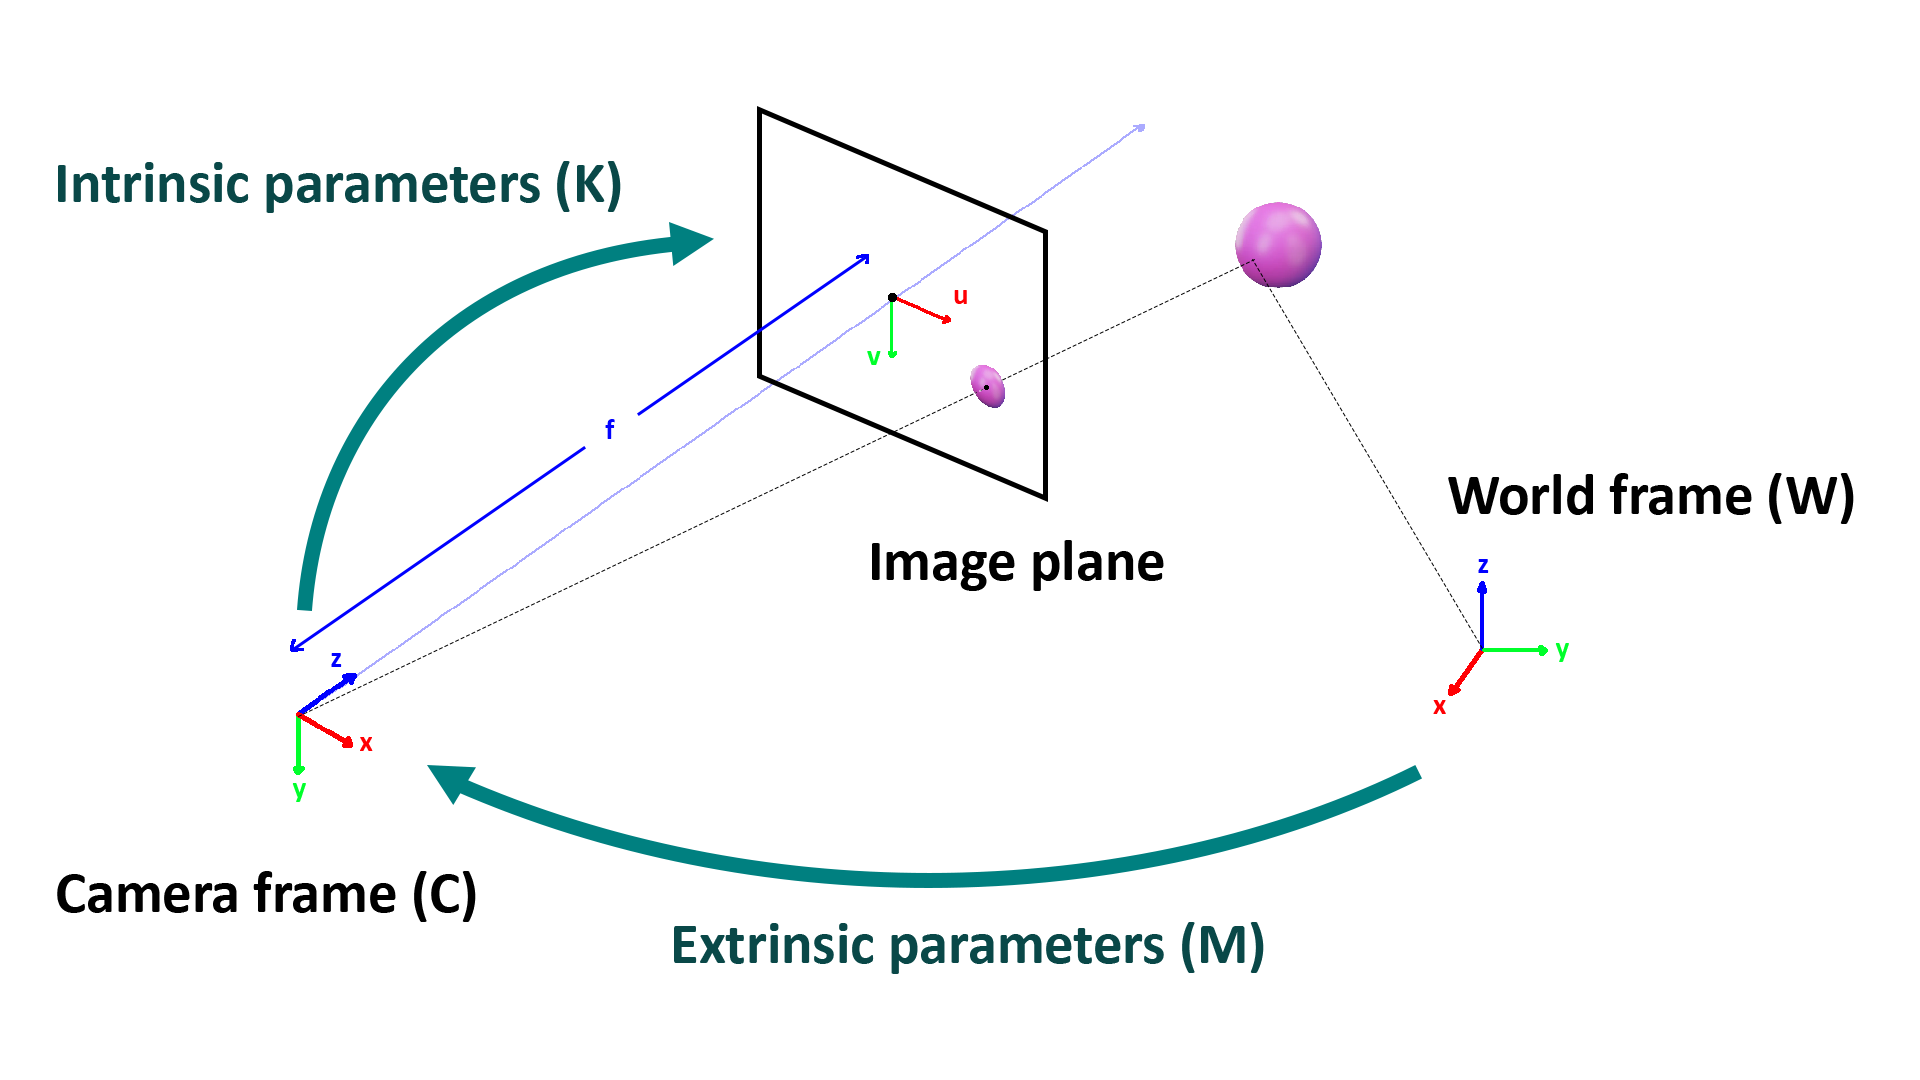

Si bien el uso de la matriz de parámetros $M$ no difiere de lo visto hasta el momento (corresponde exactamente a una matriz de transformación de 4x3), la matriz intrínseca $K$ tiene un formato un tanto distinto:

$$
K =
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

Con $f_x$ y $f_y$ las distancias focales (distancia desde el sensor de la cámara hasta el lente de la cámara) y $c_x, c_y$ los centros de la imagen `(WIDTH/2, HEIGHT/2)`

<center>
<img width = "50%" src="https://i.sstatic.net/FLGma.png">
</center>

Al hacer el producto de esta matriz por un vector de coordenadas XYZ en el marco de la cámara, obtendremos un vector tridimensional con las coordenadas (u,v) en la cámara del punto XYZ, ponderado por un valor $\lambda$ por el que podemos dividir el vector para obtener las coordenadas reales:

$$
\begin{bmatrix}
\lambda u \\
\lambda v \\
\lambda
\end{bmatrix}
=
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}\begin{bmatrix}
X \\
Y \\
Z \\
\end{bmatrix}
$$

O bien, matricialmente (para un conjunto de puntos):

$$
\begin{bmatrix}
    \lambda_1 u_1 & \lambda_1 v_1 & \lambda_1\\
    \lambda_2 u_2 & \lambda_2 v_2 & \lambda_2\\
     & (...) & \\
    \lambda_N u_N & \lambda_N v_N & \lambda_N\\
\end{bmatrix} = \begin{bmatrix}
    \hat{x_1}_c & \hat{y_1}_c & \hat{z_1}_c\\
    \hat{x_2}_c & \hat{y_2}_c & \hat{z_2}_c\\
     & (...) & \\
    \hat{x_N}_c & \hat{y_N}_c & \hat{z_N}_c\\
\end{bmatrix} K^T
$$

Esencialmente estamos usando una regla de tres entre la distancia de cada punto a la cámara y la distancia focal ($f$).

## Ejercicio 2.1 (4 ptos.)

Para este ejercicio deberás proyectar los puntos del LiDAR en el punto de vista de la cámara frontal (`"front"`). Aqui hay algunas consideraciones que deberás tener a la hora de implementar la solución:

- Las matrices en `camera_extrinsics` corresponden a transformaciones **desde el marco de cada cámara** hacia el marco del vehiculo, por tanto, para proyectar los puntos detectados por el LiDAR deberás invertir la transformada.

- Las transformadas en `camera_extrinsics` son transformadas cuadradas de 4x4, por lo que son invertibles directamente, puedes extraer su matrices de rotación y traslación (una vez invertida) similar a como fueron extraídas las de `P_b_s` anteriormente.

- En lugar de hacer la operación `R @ point + t` para proyectar cada uno de los 170372 puntos del LiDAR, puedes transformar todos al mismo tiempo mediante `all_points @ R.T + t`, esto tiene sentido al interpretarlo algebraicamente:

$$
\begin{bmatrix}
    \hat{x}_c\\
    \hat{y}_c\\
    \hat{z}_c\\
\end{bmatrix} = R
\begin{bmatrix}
    \hat{x}_w\\
    \hat{y}_w\\
    \hat{z}_w\\
\end{bmatrix}
+
\vec{t} \ \text{, for all set of points}
$$
<br>
<p align="center">
Es homologo a hacer:
</p>
<br>
$$
\begin{bmatrix}
    \hat{x_1}_c & \hat{y_1}_c & \hat{z_1}_c\\
    \hat{x_2}_c & \hat{y_2}_c & \hat{z_2}_c\\
     & (...) & \\
    \hat{x_N}_c & \hat{y_N}_c & \hat{z_N}_c\\
\end{bmatrix} = \begin{bmatrix}
    \hat{x_1}_w & \hat{y_1}_w & \hat{z_1}_w\\
    \hat{x_2}_w & \hat{y_2}_w & \hat{z_2}_w\\
     & (...) & \\
    \hat{x_N}_w & \hat{y_N}_w & \hat{z_N}_w\\
\end{bmatrix} R^T
+
\vec{t}
$$
<br>

- Una vez transformada la nube de puntos al marco de la camara, deberás solamente quedarte con los puntos en frente de la camara (es decir, puntos con $Z_c > 0$), esto puede ser llevado a cabo como:

    ```
    transformed_lidar_points = (...)  # Aqui transformas los puntos del lidar a la camara
    transformed_lidar_points = transformed_lidar_points[transformed_lidar_points[:, 2] > 0]
    ```

- Los puntos proyectados a la imagen deben ser normalizados segun su parámetro $\lambda$ (la distancia al punto), esto puede ser llevado a cabo a nivel de código como:

    ```
    projected_points = (...)    # Aqui proyectas los puntos de la camara a la imagen
    projected_points = projected_points[:, :2] / projected_points[:, 2, np.newaxis]
    ```

- Una vez proyectados, los puntos deben ser transformados a valores enteros y debemos filtrar solo aquellos puntos que se encuentren en las dimensiones de la imagen a la que buscamos proyectar:
    
    ```
    mask1 = projected_points[:, 0] > 0
    mask2 = projected_points[:, 0] < image.shape[1]     # Ancho de la imagen
    mask3 = projected_points[:, 1] > 0
    mask4 = projected_points[:, 1] < image.shape[0]     # Alto de la imagen

    mask = mask1 & mask2 & mask3 & mask4
    valid_points = projected_points[mask].astype(int)
    ```

- Finalmente, debemos tener un valor para la profundidad de cada punto y concatenarlo a nuestros puntos, esto puede ser obtenido mediante la misma máscara anterior sobre `transformed_lidar_points` mediante:
    ```
    depth_values = transformed_lidar_points[mask][:, 2]
    valid_points = np.hstack((valid_points, depth_values[:, np.newaxis]))
    ```

<br>

A grandes rasgos el código debería:
1. Invertir la matriz de características extrínsecas
2. Transformar los puntos desde el marco del vehículo al de la cámara
3. Filtrar los puntos frente a la cámara
4. Proyectar los puntos a la imagen usando la matriz de características intrínsecas
5. Normalizar los puntos según su distancia Z y transformarlos a entero
6. Extraer la profundidad de cada punto utilizando la máscara `mask` sobre los puntos proyectados y concatenarla a `valid_points`


In [ ]:
front_ext = camera_extrinsics["front"]
front_int = camera_intrinsics["front"]
image = images["front"]

front_ext_inv = # COMPLETAR

# (...)

# Los puntos proyectados en la imagen deben ser almacenados en la variable valid_points
valid_points = # COMPLETAR

In [ ]:
assert valid_points.shape == (20062, 3), "Las dimensiones del vector de salida no son correctas, recuerda que deben ser (u, v, depth)"

Ahora, visualizaremos los puntos proyectados sobre la imagen original, si los puntos se ven correctamente alineados quiere decir que fueron proyectados exitosamente.

In [ ]:
def plot_points_on_image(image, points, max_depth = 25):
    # Create a colormap
    image_copy = image.copy()
    cmap = matplotlib.colormaps['Spectral']

    for point in points:
        x, y = int(point[0]), int(point[1])
        if 0 <= x < image_copy.shape[1] and 0 <= y < image_copy.shape[0]:

            # Get the depth of the actual point
            depth = point[2]

            # Draw a point of size 3
            cv2.circle(image_copy, (x, y), 3, [255 * c for c in cmap(depth/max_depth)[:3]], -1)

    return image_copy

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(plot_points_on_image(images["front"].copy(), valid_points))
ax[0].set_title("Puntos proyectados en la imagen frontal")
ax[0].axis('off')

only_points = plot_points_on_image(np.zeros_like(image), valid_points)
mask_nonzero = np.any(only_points != 0, axis=2)

# Compute the distance transform and indices of nearest non-zero pixels
distances, nearest_indices = distance_transform_edt(~mask_nonzero, return_indices=True)

# Use nearest indices to map the value from non-zero pixels to zero pixels
filled_image = only_points[nearest_indices[0], nearest_indices[1], :]

ax[1].imshow(filled_image)
ax[1].set_title("Imagen de profundidad en base a los puntos proyectados\n(profundidad maxima = 25m)")
ax[1].axis('off')
plt.show()

## Ejercicio 2.2 (1 pto.)

Una vez proyectados los puntos exitosamente, programa la funcion `project_points(lidar_points, image, camera_ext, camera_int)`, que lleva a cabo este mismo proceso para un set de puntos, imagen y matrices entregado, devolviendo `valid_points`, una matriz de los puntos contenidos dentro de la imagen con sus coordenadas `(u, v, depth)`.

In [ ]:
def project_points(lidar_points, image, camera_ext, camera_int):

    # COMPLETAR

    return valid_points

Validaremos el funcionamiento de tu codigo generando una imagen panoramica de todas las camaras con los puntos proyectados en ellas:

In [ ]:
# Stitch two images together with a gradient inbetween
def stitch_with_blending(image_left, image_right, overlap, vertical_offset=0):
    # Get the dimensions of both images
    height_left, width_left = image_left.shape[:2]
    height_right, width_right = image_right.shape[:2]

    # Pad the shorter image to match the height of the taller image
    if height_left < height_right:
        pad_top = height_right - height_left
        image_left = np.pad(image_left, ((pad_top, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)
        height = height_right
    elif height_right < height_left:
        pad_top = height_left - height_right
        image_right = np.pad(image_right, ((pad_top, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)
        height = height_left
    else:
        height = height_left

    # Apply the vertical offset, creating a new canvas for the right image with appropriate size
    offset_image = np.zeros((height, width_right, 3), dtype=np.uint8)
    if vertical_offset > 0:
        # Move the image downwards
        offset_image[vertical_offset:height] = image_right[:height - vertical_offset]
    elif vertical_offset < 0:
        # Move the image upwards
        offset_image[:height + vertical_offset] = image_right[-vertical_offset:height]

    # Calculate the width of the stitched image and create the canvas
    stitched_width = width_left + width_right - overlap
    stitched_image = np.zeros((height, stitched_width, 3), dtype=np.uint8)

    # Copy the left image into the stitched image
    stitched_image[:, :width_left] = image_left

    # Alpha blending for the overlapping region
    alpha = np.linspace(1, 0, overlap).reshape(1, -1, 1)
    blend_left = image_left[:, width_left - overlap:] * alpha
    blend_right = offset_image[:, :overlap] * (1 - alpha)
    blended_region = blend_left + blend_right

    # Place the blended region in the stitched image
    stitched_image[:, width_left - overlap:width_left] = blended_region

    # Copy the remaining part of the right image after the blended region
    stitched_image[:, width_left:] = offset_image[:, overlap:]

    return stitched_image

# Stitch all images from the dictionary into a panorama
def stitch_image_panorama(image_dict):
    stitched_img = stitch_with_blending(image_dict["side_left"], image_dict["front_left"], 200, vertical_offset=-5)
    stitched_img = stitch_with_blending(stitched_img, image_dict["front"], 250, vertical_offset=-15)
    stitched_img = stitch_with_blending(stitched_img, image_dict["front_right"], 205, vertical_offset=-25)
    stitched_img = stitch_with_blending(stitched_img, image_dict["side_right"], 150, vertical_offset=-25)
    return stitched_img

In [ ]:
# Stitch all the cameras POV into a panoramic image
stitched_panorama = stitch_image_panorama(images)

# Stitch the POVs with the projected lidar points
projected_points_all = {cam: project_points(lidar_data, images[cam], camera_extrinsics[cam], camera_intrinsics[cam]) for cam in CAMERA_NAMES}
projected_images = {cam: plot_points_on_image(images[cam], projected_points_all[cam]) for cam in CAMERA_NAMES}
stitched_projections = stitch_image_panorama(projected_images)

projected_black = {cam: plot_points_on_image(np.zeros_like(images[cam]), projected_points_all[cam]) for cam in CAMERA_NAMES}
stitched_black = stitch_image_panorama(projected_black)

# Display the stitched image
fig, ax = plt.subplots(3, 1, figsize=(20, 10))

ax[0].imshow(stitched_panorama)
ax[0].set_title("Stitched image of all camera images")
ax[0].axis('off')

ax[1].imshow(stitched_projections)
ax[1].set_title("Stitched image of all LiDAR projections")
ax[1].axis('off')

ax[2].imshow(stitched_black)
ax[2].set_title("Stitched image of just the LiDAR points")
ax[2].axis('off')

plt.show()

---

# **3. Deteccion de Objetos 🔍📸** (2 ptos.)

Ahora que sabemos poseemos informacion de profundidad sobre nuestra imagen, nos interesa hacer inferencia sobre que se encuentra dentro de ella.

Contrario a la actividad anterior, esta vez aprovecharemos de que ya existen multiples modelos preentrenados para distintas tareas disponibles en internet, particularmente trabajaremos con la plataforma [Roboflow](https://universe.roboflow.com/), un repositorio con miles de set de datos y modelos preentrenados de acceso publico.

<center>
<a href="https://universe.roboflow.com/">
<img width = "50%" src="https://universe.roboflow.com/images/universe-opengraph.png"></a>
</center>

Para comenzar a usar la plataforma deberas crear tu propia cuenta y obtener tu clave API y poder descargar los modelos directamente desde Python (en el sitio web, arriba a la derecha, sigue los pasos de *Create an Account*.

Una vez creada tu cuenta puedes usar el buscador de Roboflow para encontrar modelos y datasets de multiples tipos, en nuestro caso, trabajaremos con el modelo preentrenado para deteccion de personas disponible [en el siguiente link](https://universe.roboflow.com/human-w5xjk/insantanima-5j91l/model/3). Para obtener tu API key deberas navegar hasta el fondo de la pagina en la pestaña *Code Snippets*, donde encontraras la `api_key` asociada a tu cuenta.

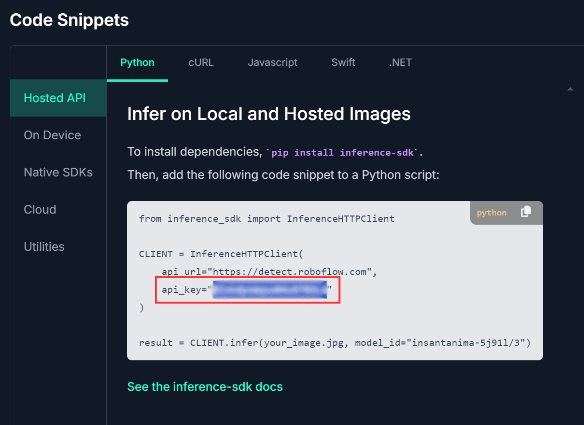

**Copia el valor de tu `api_key` y pegalo en la celda de abajo para poder descargar y usar el modelo preentrenado.**

In [ ]:
API_KEY = "" # COMPLETAR
model = get_model(model_id = "insantanima-5j91l/3", api_key = API_KEY)

In [ ]:
# Helper function to display output predictions on the image
def plot_detections(image, predictions):
    image_infer = image.copy()

    # For each prediction, draw the rect of the bounding box
    for detection in predictions:
        x_center = int(detection.x)
        y_center = int(detection.y)
        width = int(detection.width)
        height = int(detection.height)

        # Draw the bounding box
        cv2.rectangle(image_infer, (x_center - width // 2, y_center - height // 2), (x_center + width // 2, y_center + height // 2), (0, 255, 0), 2)

        # Draw the label
        label = detection.class_name

        cv2.putText(image_infer, label, (x_center - width // 2, y_center - height // 2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with bounding boxes and labels
    return image_infer

Utilizando el metodo `.infer()` del modelo, podemos hacer la deteccion de objetos dentro de la imagen. Existen dos parametros que solemos variar para esta prediccion:

- `confidence`: Minimo de certidumbre necesaria en una prediccion para ser realizada (entre 0 y 1), un valor pequeño va a ser propenso a generar falsos positivos, mientras que un valor grande puede generar falsos negativos.

- `iou_threshold`: Intersection Over Union (o IOU) es una metrica que nos permite cuantificar cuanto se sobrelapan dos rectangulos en el espacio, su formula es <br> <br> $$IOU(A, B) = \frac{A \cap B}{A \cup B}$$ <br> Graficamente, se puede representar de la siguiente manera: <center>
<img width = "50%" src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=2&strip=1&webp=1">
</center> <br> El ajuste de este parametro es usado para fusionar bounding boxes que ocupan un mismo lugar en el espacio en una sola, su ajuste permite especificar cuanto debe ser la interseccion sobre union (valor entre 0 y 1) minima para fusionar dos bounding boxes y considerarlas como una sola.

In [ ]:
image_infer = images["front"]
results = model.infer(image_infer, confidence = 0.3, iou_threshold = 0.5)[0]

print(f"There was a total of {len(results.predictions)} predictions on the image\n")
plt.imshow(plot_detections(image_infer, results.predictions))
plt.axis("off")
plt.show()

## Ejercicio 3.1 (1 pto.)

En este ejercicio vamos a experimentar con distintos valores de `confidence` y `iou_threshold`. Para ello, deberas llenar el array `experiment_imgs` de dimensiones `(4, 3, 1280, 1920, 3)` con las imagenes de cada uno de los experimentos.

Se te entregaran dos listas, `confidence_values`, de largo 4 y `iou_threshold`, de largo 3. Deberas almacenar la imagen resultante de la prediccion con `confidence[i]` y `iou_threshold[j]` en `experiment_imgs[i][j]`.

La celda siguiente se encargara de graficar los resultados.

In [ ]:
confidence_values = [0.01, 0.2, 0.6, 0.9]
iou_threshold = [0.05, 0.5, 1]

experiment_imgs = np.zeros((len(confidence_values), len(iou_threshold), image_infer.shape[0], image_infer.shape[1], image_infer.shape[2]))
print(f"experiment_imgs has shape: {experiment_imgs.shape}")

# COMPLETAR

In [ ]:
fig, ax = plt.subplots(len(iou_threshold), len(confidence_values), figsize = (20, 10.5))

for i in range(len(confidence_values)):
    for j in range(len(iou_threshold)):
        ax[j][i].imshow(experiment_imgs[i][j].astype(int))
        ax[j][i].axis("off")
        ax[j][i].set_title(f"Confidence: {confidence_values[i]}\nIOU: {iou_threshold[j]}")

plt.show()

## Ejercicio 3.2 (1 pto.)

¿Que puedes comentar sobre los resultados obtenidos, que ocurre con el numero y calidad de predicciones a medida que variamos los valores de los parametros? ¿Que valores para `confidence` y `iou_threshold` recomendarias usar? </h3>



> ESCRIBE TU RESPUESTA AQUI



Por ultimo, vamos a generar una imagen panoramica con las detecciones de cada camara, en lugar de detectar sobre cada imagen, vamos a correr el algoritmo en particiones de la imagen:

In [ ]:
# Generate a dictionary with the predictions for each image
stitched_panorama_detection = stitched_panorama.copy()

n_slices = 5
for i in range(n_slices):
    img_slice = stitched_panorama_detection[:, i * stitched_panorama_detection.shape[1] // n_slices : (i+1) * stitched_panorama_detection.shape[1] // n_slices]
    slice_prediction = model.infer(img_slice, confidence = 0.3, iou_threshold = 0.5)[0]
    stitched_panorama_detection[:, i * stitched_panorama_detection.shape[1] // n_slices : (i+1) * stitched_panorama_detection.shape[1] // n_slices] = plot_detections(img_slice, slice_prediction.predictions)

plt.figure(figsize = (20, 10))
plt.imshow(stitched_panorama_detection)
plt.title("Stitched image of cameras with object detection")
plt.axis("off")
plt.show()

---

# **4. Deteccion de Objetos + 3D 🚶‍➡️🗺️** (2 ptos.)

En este apartado aprovecharemos de la informacion 3D que disponemos sobre nuestra imagen para poder refinar nuestras predicciones y llevarlas a 3D.

<br>

Comenzaremos retomando desde las predicciones de la camara frontal del vehiculo:

In [ ]:
detection = results.predictions[0]

x_center = int(detection.x)
y_center = int(detection.y)
width = int(detection.width)
height = int(detection.height)

# Vamos a tomar solamente aquellos puntos 3D contenidos dentro de la bounding box
mask1 = projected_points_all["front"][:, 0] >= max(0, x_center - width // 2)
mask2 = projected_points_all["front"][:, 0] <= min(image_infer.shape[1], x_center + width // 2)
mask3 = projected_points_all["front"][:, 1] >= max(0, y_center - height // 2)
mask4 = projected_points_all["front"][:, 1] <= min(image_infer.shape[0], y_center + height // 2)

mask = mask1 & mask2 & mask3 & mask4
bb_depth_points = projected_points_all["front"][mask]

img_bb_points = plot_points_on_image(images["front"], bb_depth_points)
cv2.rectangle(img_bb_points, (x_center - width // 2, y_center - height // 2), (x_center + width // 2, y_center + height // 2), (0, 255, 0), 2)

plt.imshow(img_bb_points)
plt.axis("off")
plt.show()

Una consecuencia de tener la proyeccion de los puntos del LiDAR en la camara es que podemos segmentar estos puntos y estudiar sus valores de profundidad para estimar la distancia real a la que se encuentra en el objeto.

A continuacion graficamos la distribucion de los valores de profundidad para cada punto contenido en la *bounding box*:

In [ ]:
# Plot the distribution of bb_depth_points[:, 2]
plt.figure(figsize=(8, 4), dpi= 100)
sns.histplot(bb_depth_points[:, 2], color="red", label="Compact", kde=True)
plt.title("Distribution of depth values in the bounding box")
plt.xlabel("Depth value")
plt.ylabel("Number of points")
plt.show()

Notamos que los valores para la profundidad tienden a concentrarse en dos puntos; uno cercano a la camara y uno mas lejano.

Si asumimos que la *bounding box* engloba en su mayoria pixeles del objeto buscado y ademas este objeto es relativamente plano (su profundidad se mantiene en un rango relativamente pequeño), podemos definir la profundidad del objeto detectado como la moda de la distribucion de profundidades encontrada.

<br>

A nivel de codigo se ve algo asi:

In [ ]:
# Divide the data into bins (groups of values in the same range)
counts, bin_edges = np.histogram(bb_depth_points[:, 2], bins=np.linspace(0, 50, 100))
most_common_bin_index = np.argmax(counts)

# Compute the range for the most common values
bin_min, bin_max = bin_edges[most_common_bin_index : most_common_bin_index + 2]
bin_avg = (bin_min + bin_max) / 2

print(f"La profundidad estimada del peaton es de {bin_avg} metros")

Para validar que efectivamente corresponde al peaton, podemos tomar los puntos ubicados en este rango de valores (a una distancia < 0.4m) y proyectarlos de vuelta en la imagen:

In [ ]:
# Vamos a tomar solamente aquellos puntos 3D contenidos dentro de la bounding box
pedestrian_mask = np.logical_and(bb_depth_points[:, 2] >= bin_avg - 0.4, bb_depth_points[:, 2] <= bin_avg + 0.4)
pedestrian_depth_points = bb_depth_points[pedestrian_mask]

img_pedestrian_points = plot_points_on_image(images["front"], pedestrian_depth_points)
plt.figure(figsize=(10, 10))
plt.imshow(img_pedestrian_points)
plt.title("Puntos ubicados a la distancia estimada del peaton")
plt.axis("off")
plt.show()

Podemos ajustar la bounding box del peaton para solamente contener estos puntos, obteniendo mas precision!

In [ ]:
new_bbox = np.array([
    [np.min(pedestrian_depth_points[:, 0]), np.min(pedestrian_depth_points[:, 1])],
    [np.max(pedestrian_depth_points[:, 0]), np.max(pedestrian_depth_points[:, 1])]
    ]).astype(int)

img_comparaison = images["front"].copy()
cv2.rectangle(img_comparaison, (new_bbox[0, 0], new_bbox[0, 1]), (new_bbox[1, 0], new_bbox[1, 1]), (0, 255, 0), 2)
cv2.rectangle(img_comparaison, (x_center - width // 2, y_center - height // 2), (x_center + width // 2, y_center + height // 2), (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_comparaison)
plt.title("Comparacion de bounding boxes antes/despues del ajuste")
plt.axis("off")

# Add a legend for the colors
green_patch = matplotlib.patches.Patch(color="lime", label="Bounding box fitted to pointcloud")
red_patch = matplotlib.patches.Patch(color="red", label="Original bounding box")
plt.legend(handles=[green_patch, red_patch], loc="upper right")

plt.show()

## Ejercicio 4.1 (1 pto.)

Implementa las funciones `get_bounding_box_depth(image, projected_points, detection)` y `adjust_bounding_box(image, projected_points, detection)` que llevan a cabo todo el proceso de ajuste para la bounding box implementado anteriormente.

La funcion `get_bounding_box_depth()` debe:
1. Extraer la bounding box de la deteccion
2. Seleccionar los puntos de profundidad que contiene la bounding box (revisa que exista al menos un punto en ella usando `bb_depth_points.any()`, en caso de no haber, retornar -1
3. Extraer y retornar la moda de profundidad de estos puntos

La funcion `adjust_bounding_box()` debe llamar a la funcion `get_bounding_box_depth()` dentro de su funcionamiento y luego:
1. En caso de no encontrar puntos (recibir `depth = -1`, retornar la bounding bbox original en el formato estipulado mas adelante
2. Filtrar los puntos dentro de un cierto rango (0.4m a cada lado) de la moda
3. Retornar la bounding box mas pequeña que contenga a estos puntos

La bounding box retornada debe ser una matriz de numpy de tamaño (2, 2) con coordenadas `[[min_u, min_v], [max_u, max_v]]`.

*NOTA: Es importante separar la funcionalidad de estimar profundidad del resto del proceso dado que sera usada en el siguiente apartado.*

In [ ]:
def get_bounding_box_depth(image, projected_points, detection):

    # COMPLETAR

    depth = # COMPLETAR

    return depth

def adjust_bounding_box(image, projected_points, detection):

    bb_depth = get_bounding_box_depth(image, projected_points, detection)

    if bb_depth == -1:
        return # COMPLETAR

    adjusted_bbox = # COMPLETAR

    return adjusted_bbox

Mediante la siguiente celda validamos de que la funcion fue implementada exitosamente:

In [ ]:
img_fitted_bb = images["front"].copy()
results = model.infer(img_fitted_bb, confidence = 0.3, iou_threshold = 0.5)[0]

for detection in results.predictions:
    adjusted_bbox = adjust_bounding_box(img_fitted_bb, projected_points_all["front"], detection)
    x, y, w, h = int(detection.x), int(detection.y), int(detection.width), int(detection.height)
    cv2.rectangle(img_fitted_bb, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (255, 0, 0), 2)
    cv2.rectangle(img_fitted_bb, (adjusted_bbox[0, 0], adjusted_bbox[0, 1]), (adjusted_bbox[1, 0], adjusted_bbox[1, 1]), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_fitted_bb)
plt.title("Bounding box ajustada para la imagen frontal")
plt.axis("off")

# Add a legend for the colors
green_patch = matplotlib.patches.Patch(color="lime", label="Bounding box fitted to pointcloud")
red_patch = matplotlib.patches.Patch(color="red", label="Original bounding box")
plt.legend(handles=[green_patch, red_patch], loc="upper right")

plt.show()

Funciona muy bien! *¿cierto?* Veamos si probamos nuestra funcion en todas las imagenes y construimos una panoramica:

In [ ]:
# Generate a dictionary with the predictions for each image
adjusted_bb_predictions = {}

for k, v in images.items():
    pov_copy = v.copy()
    original_bbx = []
    fitted_bbx = []

    pov_prediction = model.infer(pov_copy, confidence = 0.3, iou_threshold = 0.5)[0]
    for prediction in pov_prediction.predictions:
        fitted_bbx.append(adjust_bounding_box(pov_copy, projected_points_all[k], prediction))
        original_bbx.append(np.array([[prediction.x - prediction.width // 2, prediction.y - prediction.height // 2], [prediction.x + prediction.width // 2, prediction.y + prediction.height // 2]]).astype(int))

    for original, fitted in zip(original_bbx, fitted_bbx):
        cv2.rectangle(pov_copy, (original[0, 0], original[0, 1]), (original[1, 0], original[1, 1]), (255, 0, 0), 2)
        cv2.rectangle(pov_copy, (fitted[0, 0], fitted[0, 1]), (fitted[1, 0], fitted[1, 1]), (0, 255, 0), 2)

    adjusted_bb_predictions[k] = pov_copy

stitched_panorama_fitted_bb = stitch_image_panorama(adjusted_bb_predictions)

plt.figure(figsize = (20, 10))
plt.imshow(stitched_panorama_fitted_bb)
plt.title("Stitched image of cameras with object detection")
plt.axis("off")

# Add a legend for the colors
green_patch = matplotlib.patches.Patch(color="lime", label="Bounding box fitted to pointcloud")
red_patch = matplotlib.patches.Patch(color="red", label="Original bounding box")
plt.legend(handles=[green_patch, red_patch], loc="upper right")

plt.show()

## Ejercicio 4.2 (1 pto.)

¿Que error notas en el retorno de la celda pasada? ¿Que crees que podria ocacionar el fallo en el ajuste de la bounding box? Propone o investiga un metodo alternativo para estimar la profundidad de una bounding box con datos de profundidad.

*TIP: Recuerda que hicimos una asunción bastante grande para implementar esta tecnica*



> ESCRIBE TU RESPUESTA AQUI



---

# **5. Proyeccion de 2D a 3D 🖼️→🛣️** (3 ptos.)

Por ultimo, usaremos la informacion de profundidad y la matriz intrinseca de nuestra camera para proyectar las bounding boxes de 2D dimensiones a un set de puntos en 3D que luego visualizaremos y compararemos con las etiquetas reales del dataset.

<br>

Recordando del apartado 2, podemos proyectar un punto desde 3 a 2 dimensiones utilizando la matriz intrinseca de la camara a la que se busca proyectar:

<center>
<img width = "50%" src="https://i.sstatic.net/FLGma.png">
</center>

Notamos que podemos obtener de vuelta el punto $x$ a partir de $u$, los parametros de la matriz intrinseca y la distancia $z$, todos conocidos por nosotros. Despejamos entonces las expresiones:

$$
x = \frac{u - c_x}{f_x} \cdot z \\
y = \frac{v - c_y}{f_y} \cdot z
$$

Recordando que $K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$ y que podemos estimar (con cierto grado de exito) la profundidad de la bounding box buscada.

In [ ]:
detection = results.predictions[0]

x_center = int(detection.x)
y_center = int(detection.y)
width = int(detection.width)
height = int(detection.height)

bb_corners = np.array([
    [x_center - width // 2, y_center - height // 2],
    [x_center + width // 2, y_center - height // 2],
    [x_center + width // 2, y_center + height // 2],
    [x_center - width // 2, y_center + height // 2]
])

front_copy = images["front"].copy()

for corner in bb_corners:
    cv2.circle(front_copy, (corner[0], corner[1]), 5, (255, 0, 0), -1)

plt.figure(figsize = (5, 5))
plt.imshow(front_copy)
plt.title("Bounding box corners")
plt.axis("off")
plt.show()

## Ejercicio 5.1 (2 ptos.)

Usando las siguientes ecuaciones:
$$
x = \frac{u - c_x}{f_x} \cdot z \\
y = \frac{v - c_y}{f_y} \cdot z
$$

Programa la funcion `project_bb_to_3d(image, projected_points, detection, intrinsics_matrix)` que extrae las esquinas de la bounding box (en el mismo orden que en la demostracion anterior) y retorna una serie de 8 puntos en 3 dimensiones correspondientes a la bounding box en el marco de la camara.

Esta funcion debe:
1. Extraer la profundidad de la bounding box detectada usando la funcion programada anteriormente `get_bounding_box_depth(image, projected_points, detection)`, en caso de retornar -1, retornar `np.zeros((8, 3))`
2. Computar las coordenadas (u, v) de las esquinas de la bounding box
3. Para cada esquina de la bounding box, proyectar sus coordenadas de 2D a 3D usando las formulas anteriores (el valor de z es el extraido en 1.)

Habiendo terminado el paso anterior, deberias contar con una matriz de tamaño (4, 3). Diremos que este corresponde a la *cara mas cercana* de la bounding box a la camara.

Asumiremos (con un cierto grado de certidumbre) que un peaton en su profundidad mas ancha mide 0.5m, por tanto, generaremos un segundo set de puntos en 3D $0.5$ metros mas alejados de los anteriores, construyendo asi una bounding box en 3D:

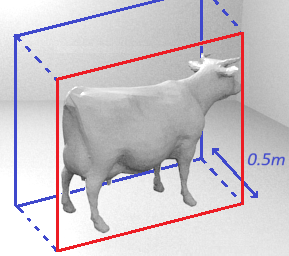

En rojo tendriamos la bounding box original, proyectada a 3D y generariamos su cara trasera (opuesta a la camara, en color azul), 0.5 metros detras para generar un poligono completo.

Por tanto la funcion, tambien tendria que:
4. Duplicar las coordenadas de la bounding box y trasladar la segunda copia.

Esto puede ser llevado a cabo a nivel de codigo de la siguiente forma:
```
# bb_corners_3d es una matriz de (4, 3) con las coordenadas en 3D de cada vertice de la bounding box original
bb_corners_3d = np.vstack((bb_corners_3d, bb_corners_3d))
bb_corners_3d[:4, 2] -= 0.25
bb_corners_3d[4:, 2] += 0.25

return bb_corners_3d
```

Despues de estas lineas, `bb_corners_3d` tiene dimensiones `(8, 3)` y puede ser finalmente retornada por la funcion.

In [ ]:
def project_bb_to_3d(image, projected_points, detection, intrinsics_matrix):
    bb_depth = get_bounding_box_depth(image, projected_points, detection)

    if bb_depth == -1:
        # COMPLETAR
        return

    # COMPLETAR

    return bb_corners_3d

Primero, probaremos la funcion proyectando la bounding box 3D de vuelta al marco de la imagen:

In [ ]:
def plot_3dbbox_image(image, bbox_corners, camera_int):
    # Input bbox is in format (top_left_front, top_right_front, bottom_right_front, ...)

    # Project the corners of the 3D bounding box to the camera
    projected_bb_corners = np.dot(bbox_corners, camera_int.T)
    projected_bb_corners = projected_bb_corners[:, :2] / projected_bb_corners[:, 2, np.newaxis]
    projected_bb_corners = projected_bb_corners[:, :2].astype(int)

    # Draw the 3D bounding box on the image
    img_copy = image.copy()

    cv2.rectangle(img_copy, (projected_bb_corners[4][0], projected_bb_corners[4][1]), (projected_bb_corners[6][0], projected_bb_corners[6][1]), (0, 0, 255), 2)
    cv2.line(img_copy, (projected_bb_corners[0][0], projected_bb_corners[0][1]), (projected_bb_corners[4][0], projected_bb_corners[4][1]), (0, 255, 0), 2)
    cv2.line(img_copy, (projected_bb_corners[1][0], projected_bb_corners[1][1]), (projected_bb_corners[5][0], projected_bb_corners[5][1]), (0, 255, 0), 2)
    cv2.line(img_copy, (projected_bb_corners[2][0], projected_bb_corners[2][1]), (projected_bb_corners[6][0], projected_bb_corners[6][1]), (0, 255, 0), 2)
    cv2.line(img_copy, (projected_bb_corners[3][0], projected_bb_corners[3][1]), (projected_bb_corners[7][0], projected_bb_corners[7][1]), (0, 255, 0), 2)
    cv2.rectangle(img_copy, (projected_bb_corners[0][0], projected_bb_corners[0][1]), (projected_bb_corners[2][0], projected_bb_corners[2][1]), (255, 0, 0), 2)

    return img_copy

In [ ]:
image_front = images["front"].copy()
detection = results.predictions[0]
front_intrinsics = camera_intrinsics["front"]

bbox_3d = project_bb_to_3d(image_front, projected_points_all["front"], detection, front_intrinsics)
image_front = plot_3dbbox_image(image_front, bbox_3d, front_intrinsics)

plt.imshow(image_front)
plt.axis("off")
plt.title("Bounding box proyectado a 3D")
plt.show()

En caso de funcionar de manera exitosa, podemos usar la funcion para todas las detecciones en la escena, proyectando ademas los puntos desde el marco de referencia la camara hacia el marco de referencia del vehiculo:

In [ ]:
all_projected_bboxes = []

# Para cada camara, proyectamos cada una de sus bounding boxes a 3D
for camera_name in CAMERA_NAMES:
    cam_image = images[camera_name].copy()
    cam_intrinsics = camera_intrinsics[camera_name]
    cam_extrinsics = camera_extrinsics[camera_name]
    cam_projected_points = projected_points_all[camera_name]

    results = model.infer(cam_image, confidence = 0.3, iou_threshold = 0.5)[0]

    for detection in results.predictions:
        bbox_3d = project_bb_to_3d(cam_image, cam_projected_points, detection, cam_intrinsics)

        # Transformamos desde el marco de la camara al del vehiculo
        cam_rot = cam_extrinsics[:3, :3]
        cam_trans = cam_extrinsics[:3, 3]
        bbox_3d = np.dot(bbox_3d, cam_rot.T) + cam_trans

        all_projected_bboxes.append(bbox_3d)

all_projected_bboxes = np.array(all_projected_bboxes)
all_projected_bboxes_ids = np.full(all_projected_bboxes.shape[0], 1)

print(f"all_projected_bboxes.shape: {all_projected_bboxes.shape}")

Visualizamos los puntos 3D con las bounding boxes encontradas:

In [ ]:
# Visualizamos los puntos del LiDAR y las bounding box predichas de cada peaton
plot_map(lidar_data, all_projected_bboxes, all_projected_bboxes_ids)

Finalmente, graficamos en conjunto las predicciones reales de peatones (en rojo) y las estimadas mediante la proyeccion (en verde).

In [ ]:
label_pedestrians_mask = np.where(label_ids == 2)
label_pedestrian_bbox = label_bbox[label_pedestrians_mask]
label_pedestrian_ids = label_ids[label_pedestrians_mask]

projected_bboxes_ids = np.full(all_projected_bboxes.shape[0], 1)

combined_ids = np.concatenate((projected_bboxes_ids, label_pedestrian_ids))
combined_bboxes = np.concatenate((all_projected_bboxes, label_pedestrian_bbox))

print(f"combined_bboxes.shape: {combined_bboxes.shape}")
print(f"combined_ids.shape: {combined_ids.shape}")

In [ ]:
# Visualizamos los puntos del LiDAR y las bounding box reales de cada objeto
plot_map(lidar_data, combined_bboxes, combined_ids)

## Ejercicio 5.2 (1 pto.)

¿Que diferencias notas entre las prediccciones hechas y las posiciones reales de los peatones? ¿Que crees que podria ocacionar esto? ¿Fue certera nuestra prediccion para algunos peatones?

*TIP: Se trata del mismo problema que tuvimos en el item 4.2*



> ESCRIBE TU RESPUESTA AQUI



---

# Cierre de la actividad

Felicitaciones, has terminado nuestra tercera y ultima actividad del curso, asegurate de que todas las celdas hayan sido corridas exitosamente (y que se puedan visualizar sus salidas) y descarga el archivo ```.ipynb``` para subirlo a Canvas :)